# London Cycle Count Analysis

- We cleaned the data and commenced exploratory data analysis, which highlighted that men cycle more than women and that private cycles are used more than hired cycles.  
- We created a CatBoost regressor model and ran a Shapley analysis to determine which features were the most important for predicting the number of cyclists, finding that the number of cycle parking areas within 1000 metres is the most important feature.  

### London Data

Here we load and pre-process the London cycling data from TfL.

In [1]:
# If packages are not installed on your machine, run the !pip install command, e.g.
#!pip install catboost 

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import shap
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('london_count_sites/Inner London.csv')
outer = pd.read_csv('london_count_sites/Outer London.csv')
central = pd.read_csv('london_count_sites/Central London.csv')

In [3]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [4]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [5]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

# days appear to be recorded in abbreviated French, e.g. lundi, mardi...
day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [6]:
# Drop columns less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [7]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [8]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [9]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

### Exploratory Data Analysis 
Here we create some quick plots to identify any differences in cycling rates. These plots will not be displayed to stakeholders, so appearance is less important.

Text(0.5, 0, 'Number of cyclists')

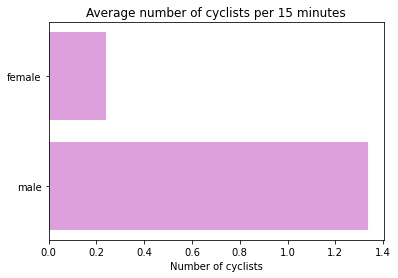

In [10]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

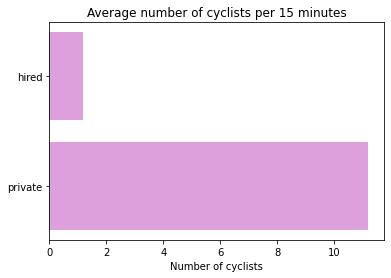

In [11]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

### Infrastructure Data
Here we merge with the TfL infrastructure data, which was pre-processed in __infrastructure_data_final.ipynb__.

In [12]:
# Get borough of each London site 
sites = pd.read_excel('london_count_sites/Biking sites.xlsx')[[
    'UnqID', 'Borough']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(sites, how='left', on='site')

# Group london data by borough
london_boroughs = london.groupby(['borough']).mean()[['total_cycles']].reset_index()

In [13]:
# Get borough infrastructure data 
borough_df = pd.read_csv('london_infrastructure/borough_infrastructure.csv')

In [14]:
# Merge borough data together
borough_df = pd.merge(london_boroughs, borough_df, how='outer', on='borough')

# Correlations between mean cyclists and surveyed infrastructure 
for col in ['cycle_parking_count', 'restricted_point_count', 'signage_count', 'signal_count', 
            'traffic_calming_count', 'crossing_distance_covered', 'advanced_stop_line_distance_covered', 
            'restricted_route_distance_covered', 'cycle_lane_track_distance_covered']:
    print(col, '\n', np.corrcoef(borough_df['total_cycles'], borough_df[col]), '\n')

cycle_parking_count 
 [[1.         0.58849277]
 [0.58849277 1.        ]] 

restricted_point_count 
 [[ 1.         -0.13278599]
 [-0.13278599  1.        ]] 

signage_count 
 [[1.        0.0227193]
 [0.0227193 1.       ]] 

signal_count 
 [[1.         0.75412353]
 [0.75412353 1.        ]] 

traffic_calming_count 
 [[ 1.         -0.00523325]
 [-0.00523325  1.        ]] 

crossing_distance_covered 
 [[ 1.         -0.43127978]
 [-0.43127978  1.        ]] 

advanced_stop_line_distance_covered 
 [[1.         0.65292264]
 [0.65292264 1.        ]] 

restricted_route_distance_covered 
 [[1.         0.28345256]
 [0.28345256 1.        ]] 

cycle_lane_track_distance_covered 
 [[ 1.       -0.405039]
 [-0.405039  1.      ]] 



### Modelling 
Here we run a CatBoost model, using Shapley values to determine the importance of each feature. 
We selected a CatBoost model as this is a powerful machine learning method, well-equipped to handle categorical data. 

In [15]:
# Load distance to infrastructure data 
updated_sites = pd.read_csv('london_count_sites/updated_sites.csv')

In [16]:
# Add infrastructure data to dataframe 

distance_data = updated_sites[['UnqID', 'closest_restricted_point', 'restricted_point_count_100m',
 'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 'signal_count_1000m',
 'closest_cycle_parking', 'cycle_parking_count_100m', 'cycle_parking_count_1000m']].rename(columns={'UnqID':'site'})

london = london.merge(distance_data, how='left', on='site')

In [17]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 
                       'total_cycles', 'closest_restricted_point', 'restricted_point_count_100m', 
                       'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 
                       'signal_count_1000m', 'closest_cycle_parking', 'cycle_parking_count_100m', 
                       'cycle_parking_count_1000m']]

# Exclude rows with null values 
london_model = london_model.dropna()

# ~1.6% of total rows dropped
(london_model.shape[0]/london.shape[0])*100

98.41891796508082

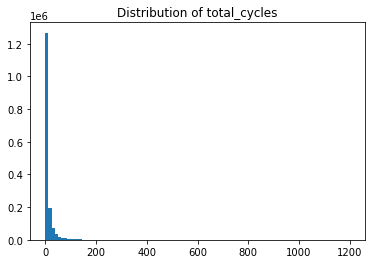

Rows: 1631391
Rows after dropping outliers: 1628368


In [18]:
# Plot distribution  
plt.hist(london_model.total_cycles, bins=100)
plt.title('Distribution of total_cycles')
plt.show()

# Exclude outliers as these may impact the model  
print(f'Rows: {london_model.shape[0]}')
london_model = london_model[london_model['total_cycles']<200]
print(f'Rows after dropping outliers: {london_model.shape[0]}')

In [19]:
# Change month column from float to int
london_model.month = london_model.month.astype(int)

# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [22]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=10000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.3569587	test: -1.3646704	best: -1.3646704 (0)	total: 3.33s	remaining: 9h 14m 25s
1:	learn: -3.4457143	test: -3.4610513	best: -3.4610513 (1)	total: 5.58s	remaining: 7h 44m 33s
2:	learn: -5.2781336	test: -5.3006812	best: -5.3006812 (2)	total: 7.77s	remaining: 7h 11m 46s
3:	learn: -6.8870223	test: -6.9154798	best: -6.9154798 (3)	total: 9.85s	remaining: 6h 50m 18s
4:	learn: -8.3030118	test: -8.3377848	best: -8.3377848 (4)	total: 11.9s	remaining: 6h 35m 59s
5:	learn: -9.5234190	test: -9.5636292	best: -9.5636292 (5)	total: 13.7s	remaining: 6h 20m 10s
6:	learn: -10.5840101	test: -10.6288133	best: -10.6288133 (6)	total: 15.5s	remaining: 6h 8m 52s
7:	learn: -11.5019972	test: -11.5505667	best: -11.5505667 (7)	total: 17.3s	remaining: 5h 59m 32s
8:	learn: -12.2873715	test: -12.3389154	best: -12.3389154 (8)	total: 18.9s	remaining: 5h 49m 54s
9:	learn: -12.9712407	test: -13.0258666	best: -13.0258666 (9)	total: 20.7s	remaining: 5h 44m 37s
10:	learn: -13.5773603	test: -13.6346348	best: -1

84:	learn: -18.2620367	test: -18.3046665	best: -18.3046665 (84)	total: 2m 30s	remaining: 4h 52m 43s
85:	learn: -18.2671810	test: -18.3095409	best: -18.3095409 (85)	total: 2m 32s	remaining: 4h 52m 17s
86:	learn: -18.2748349	test: -18.3174454	best: -18.3174454 (86)	total: 2m 33s	remaining: 4h 52m
87:	learn: -18.2781211	test: -18.3197023	best: -18.3197023 (87)	total: 2m 35s	remaining: 4h 51m 46s
88:	learn: -18.2858771	test: -18.3273283	best: -18.3273283 (88)	total: 2m 37s	remaining: 4h 51m 35s
89:	learn: -18.2934657	test: -18.3349275	best: -18.3349275 (89)	total: 2m 38s	remaining: 4h 51m 10s
90:	learn: -18.3018502	test: -18.3430965	best: -18.3430965 (90)	total: 2m 40s	remaining: 4h 50m 41s
91:	learn: -18.3068225	test: -18.3477110	best: -18.3477110 (91)	total: 2m 42s	remaining: 4h 50m 47s
92:	learn: -18.3113401	test: -18.3514321	best: -18.3514321 (92)	total: 2m 43s	remaining: 4h 50m 43s
93:	learn: -18.3347187	test: -18.3746124	best: -18.3746124 (93)	total: 2m 45s	remaining: 4h 50m 17s
94:	

166:	learn: -18.6952933	test: -18.7261138	best: -18.7261138 (166)	total: 4m 57s	remaining: 4h 52m 22s
167:	learn: -18.6979088	test: -18.7285213	best: -18.7285213 (167)	total: 5m	remaining: 4h 53m 14s
168:	learn: -18.6996349	test: -18.7300942	best: -18.7300942 (168)	total: 5m 2s	remaining: 4h 53m 27s
169:	learn: -18.7065187	test: -18.7370202	best: -18.7370202 (169)	total: 5m 4s	remaining: 4h 53m 20s
170:	learn: -18.7077813	test: -18.7382775	best: -18.7382775 (170)	total: 5m 5s	remaining: 4h 53m 7s
171:	learn: -18.7101202	test: -18.7405614	best: -18.7405614 (171)	total: 5m 7s	remaining: 4h 53m 9s
172:	learn: -18.7133919	test: -18.7437202	best: -18.7437202 (172)	total: 5m 9s	remaining: 4h 53m 13s
173:	learn: -18.7165617	test: -18.7469086	best: -18.7469086 (173)	total: 5m 11s	remaining: 4h 53m 17s
174:	learn: -18.7197547	test: -18.7498939	best: -18.7498939 (174)	total: 5m 13s	remaining: 4h 53m 18s
175:	learn: -18.7213477	test: -18.7516019	best: -18.7516019 (175)	total: 5m 15s	remaining: 4h

247:	learn: -18.8538036	test: -18.8677548	best: -18.8677548 (247)	total: 7m 27s	remaining: 4h 53m 26s
248:	learn: -18.8545937	test: -18.8681603	best: -18.8681603 (248)	total: 7m 29s	remaining: 4h 53m 17s
249:	learn: -18.8580318	test: -18.8714210	best: -18.8714210 (249)	total: 7m 31s	remaining: 4h 53m 25s
250:	learn: -18.8582897	test: -18.8715102	best: -18.8715102 (250)	total: 7m 33s	remaining: 4h 53m 22s
251:	learn: -18.8602252	test: -18.8732844	best: -18.8732844 (251)	total: 7m 34s	remaining: 4h 53m 8s
252:	learn: -18.8606237	test: -18.8736037	best: -18.8736037 (252)	total: 7m 36s	remaining: 4h 53m 1s
253:	learn: -18.8618251	test: -18.8744736	best: -18.8744736 (253)	total: 7m 38s	remaining: 4h 52m 57s
254:	learn: -18.8629118	test: -18.8746763	best: -18.8746763 (254)	total: 7m 39s	remaining: 4h 52m 55s
255:	learn: -18.8642019	test: -18.8757985	best: -18.8757985 (255)	total: 7m 41s	remaining: 4h 52m 55s
256:	learn: -18.8658171	test: -18.8775103	best: -18.8775103 (256)	total: 7m 43s	rema

328:	learn: -18.9539534	test: -18.9514526	best: -18.9514526 (328)	total: 9m 52s	remaining: 4h 50m 11s
329:	learn: -18.9551034	test: -18.9525156	best: -18.9525156 (329)	total: 9m 54s	remaining: 4h 50m 11s
330:	learn: -18.9577959	test: -18.9550657	best: -18.9550657 (330)	total: 9m 55s	remaining: 4h 50m 9s
331:	learn: -18.9601335	test: -18.9573746	best: -18.9573746 (331)	total: 9m 57s	remaining: 4h 50m
332:	learn: -18.9608544	test: -18.9580255	best: -18.9580255 (332)	total: 9m 59s	remaining: 4h 49m 57s
333:	learn: -18.9618275	test: -18.9587111	best: -18.9587111 (333)	total: 10m 1s	remaining: 4h 49m 54s
334:	learn: -18.9626202	test: -18.9592513	best: -18.9592513 (334)	total: 10m 3s	remaining: 4h 49m 59s
335:	learn: -18.9631979	test: -18.9595664	best: -18.9595664 (335)	total: 10m 4s	remaining: 4h 49m 59s
336:	learn: -18.9642796	test: -18.9602489	best: -18.9602489 (336)	total: 10m 7s	remaining: 4h 50m 7s
337:	learn: -18.9653071	test: -18.9611779	best: -18.9611779 (337)	total: 10m 8s	remainin

409:	learn: -19.0165185	test: -18.9919324	best: -18.9920040 (408)	total: 12m 18s	remaining: 4h 47m 52s
410:	learn: -19.0167395	test: -18.9919055	best: -18.9920040 (408)	total: 12m 20s	remaining: 4h 47m 49s
411:	learn: -19.0170314	test: -18.9919147	best: -18.9920040 (408)	total: 12m 22s	remaining: 4h 47m 49s
412:	learn: -19.0173153	test: -18.9919339	best: -18.9920040 (408)	total: 12m 23s	remaining: 4h 47m 48s
413:	learn: -19.0179820	test: -18.9925078	best: -18.9925078 (413)	total: 12m 25s	remaining: 4h 47m 41s
414:	learn: -19.0186152	test: -18.9924623	best: -18.9925078 (413)	total: 12m 27s	remaining: 4h 47m 38s
415:	learn: -19.0189179	test: -18.9925674	best: -18.9925674 (415)	total: 12m 29s	remaining: 4h 47m 43s
416:	learn: -19.0195806	test: -18.9926754	best: -18.9926754 (416)	total: 12m 31s	remaining: 4h 47m 38s
417:	learn: -19.0199112	test: -18.9928354	best: -18.9928354 (417)	total: 12m 32s	remaining: 4h 47m 34s
418:	learn: -19.0202275	test: -18.9929210	best: -18.9929210 (418)	total: 

489:	learn: -19.0639233	test: -19.0224292	best: -19.0224292 (489)	total: 14m 46s	remaining: 4h 46m 40s
490:	learn: -19.0646492	test: -19.0229066	best: -19.0229066 (490)	total: 14m 47s	remaining: 4h 46m 37s
491:	learn: -19.0651749	test: -19.0232391	best: -19.0232391 (491)	total: 14m 49s	remaining: 4h 46m 32s
492:	learn: -19.0653433	test: -19.0232718	best: -19.0232718 (492)	total: 14m 51s	remaining: 4h 46m 32s
493:	learn: -19.0661608	test: -19.0239687	best: -19.0239687 (493)	total: 14m 53s	remaining: 4h 46m 32s
494:	learn: -19.0664046	test: -19.0239907	best: -19.0239907 (494)	total: 14m 55s	remaining: 4h 46m 32s
495:	learn: -19.0665442	test: -19.0239422	best: -19.0239907 (494)	total: 14m 57s	remaining: 4h 46m 32s
496:	learn: -19.0669957	test: -19.0238673	best: -19.0239907 (494)	total: 14m 59s	remaining: 4h 46m 33s
497:	learn: -19.0671681	test: -19.0238194	best: -19.0239907 (494)	total: 15m	remaining: 4h 46m 22s
498:	learn: -19.0675080	test: -19.0239086	best: -19.0239907 (494)	total: 15m 

570:	learn: -19.1003446	test: -19.0393237	best: -19.0393555 (566)	total: 17m 18s	remaining: 4h 45m 41s
571:	learn: -19.1003895	test: -19.0393321	best: -19.0393555 (566)	total: 17m 19s	remaining: 4h 45m 41s
572:	learn: -19.1004342	test: -19.0393319	best: -19.0393555 (566)	total: 17m 21s	remaining: 4h 45m 35s
573:	learn: -19.1006078	test: -19.0393389	best: -19.0393555 (566)	total: 17m 23s	remaining: 4h 45m 37s
574:	learn: -19.1008380	test: -19.0392976	best: -19.0393555 (566)	total: 17m 25s	remaining: 4h 45m 37s
575:	learn: -19.1008673	test: -19.0393016	best: -19.0393555 (566)	total: 17m 27s	remaining: 4h 45m 31s
576:	learn: -19.1009175	test: -19.0393066	best: -19.0393555 (566)	total: 17m 28s	remaining: 4h 45m 23s
577:	learn: -19.1012959	test: -19.0395487	best: -19.0395487 (577)	total: 17m 30s	remaining: 4h 45m 29s
578:	learn: -19.1014235	test: -19.0395813	best: -19.0395813 (578)	total: 17m 33s	remaining: 4h 45m 37s
579:	learn: -19.1019876	test: -19.0396159	best: -19.0396159 (579)	total: 

650:	learn: -19.1312662	test: -19.0547775	best: -19.0547775 (650)	total: 19m 49s	remaining: 4h 44m 39s
651:	learn: -19.1316177	test: -19.0547690	best: -19.0547775 (650)	total: 19m 51s	remaining: 4h 44m 44s
652:	learn: -19.1316879	test: -19.0547925	best: -19.0547925 (652)	total: 19m 53s	remaining: 4h 44m 48s
653:	learn: -19.1319531	test: -19.0547641	best: -19.0547925 (652)	total: 19m 55s	remaining: 4h 44m 49s
654:	learn: -19.1322016	test: -19.0547912	best: -19.0547925 (652)	total: 19m 58s	remaining: 4h 44m 55s
655:	learn: -19.1323510	test: -19.0548250	best: -19.0548250 (655)	total: 20m	remaining: 4h 44m 59s
656:	learn: -19.1326599	test: -19.0549426	best: -19.0549426 (656)	total: 20m 2s	remaining: 4h 44m 53s
657:	learn: -19.1331747	test: -19.0552407	best: -19.0552407 (657)	total: 20m 3s	remaining: 4h 44m 49s
658:	learn: -19.1332006	test: -19.0552381	best: -19.0552407 (657)	total: 20m 5s	remaining: 4h 44m 46s
659:	learn: -19.1332591	test: -19.0552422	best: -19.0552422 (659)	total: 20m 7s	

731:	learn: -19.1540502	test: -19.0619504	best: -19.0619889 (727)	total: 22m 23s	remaining: 4h 43m 30s
732:	learn: -19.1543992	test: -19.0620568	best: -19.0620568 (732)	total: 22m 25s	remaining: 4h 43m 34s
733:	learn: -19.1545082	test: -19.0620745	best: -19.0620745 (733)	total: 22m 27s	remaining: 4h 43m 35s
734:	learn: -19.1545683	test: -19.0620797	best: -19.0620797 (734)	total: 22m 30s	remaining: 4h 43m 37s
735:	learn: -19.1547931	test: -19.0621895	best: -19.0621895 (735)	total: 22m 32s	remaining: 4h 43m 39s
736:	learn: -19.1552935	test: -19.0621803	best: -19.0621895 (735)	total: 22m 34s	remaining: 4h 43m 39s
737:	learn: -19.1554768	test: -19.0621467	best: -19.0621895 (735)	total: 22m 36s	remaining: 4h 43m 45s
738:	learn: -19.1555671	test: -19.0621133	best: -19.0621895 (735)	total: 22m 38s	remaining: 4h 43m 44s
739:	learn: -19.1562336	test: -19.0627654	best: -19.0627654 (739)	total: 22m 40s	remaining: 4h 43m 46s
740:	learn: -19.1563645	test: -19.0627777	best: -19.0627777 (740)	total: 

811:	learn: -19.1790677	test: -19.0728508	best: -19.0728508 (811)	total: 25m 9s	remaining: 4h 44m 43s
812:	learn: -19.1792674	test: -19.0729884	best: -19.0729884 (812)	total: 25m 11s	remaining: 4h 44m 39s
813:	learn: -19.1796359	test: -19.0733229	best: -19.0733229 (813)	total: 25m 13s	remaining: 4h 44m 38s
814:	learn: -19.1797317	test: -19.0733036	best: -19.0733229 (813)	total: 25m 15s	remaining: 4h 44m 38s
815:	learn: -19.1798318	test: -19.0733977	best: -19.0733977 (815)	total: 25m 17s	remaining: 4h 44m 42s
816:	learn: -19.1802140	test: -19.0735149	best: -19.0735149 (816)	total: 25m 19s	remaining: 4h 44m 39s
817:	learn: -19.1804712	test: -19.0735587	best: -19.0735587 (817)	total: 25m 21s	remaining: 4h 44m 38s
818:	learn: -19.1806040	test: -19.0735727	best: -19.0735727 (818)	total: 25m 23s	remaining: 4h 44m 34s
819:	learn: -19.1806872	test: -19.0735920	best: -19.0735920 (819)	total: 25m 25s	remaining: 4h 44m 35s
820:	learn: -19.1809236	test: -19.0735939	best: -19.0735939 (820)	total: 2

891:	learn: -19.1999510	test: -19.0784441	best: -19.0784441 (891)	total: 27m 56s	remaining: 4h 45m 19s
892:	learn: -19.2000970	test: -19.0784422	best: -19.0784441 (891)	total: 27m 58s	remaining: 4h 45m 19s
893:	learn: -19.2003776	test: -19.0784401	best: -19.0784441 (891)	total: 28m	remaining: 4h 45m 17s
894:	learn: -19.2004577	test: -19.0784502	best: -19.0784502 (894)	total: 28m 2s	remaining: 4h 45m 16s
895:	learn: -19.2005707	test: -19.0785362	best: -19.0785362 (895)	total: 28m 4s	remaining: 4h 45m 11s
896:	learn: -19.2006706	test: -19.0785333	best: -19.0785362 (895)	total: 28m 6s	remaining: 4h 45m 11s
897:	learn: -19.2010471	test: -19.0784940	best: -19.0785362 (895)	total: 28m 8s	remaining: 4h 45m 11s
898:	learn: -19.2013923	test: -19.0787019	best: -19.0787019 (898)	total: 28m 10s	remaining: 4h 45m 9s
899:	learn: -19.2016300	test: -19.0787168	best: -19.0787168 (899)	total: 28m 11s	remaining: 4h 45m 6s
900:	learn: -19.2018163	test: -19.0787402	best: -19.0787402 (900)	total: 28m 13s	re

972:	learn: -19.2158482	test: -19.0823002	best: -19.0824795 (964)	total: 30m 37s	remaining: 4h 44m 5s
973:	learn: -19.2159733	test: -19.0823601	best: -19.0824795 (964)	total: 30m 39s	remaining: 4h 44m 6s
974:	learn: -19.2161038	test: -19.0823246	best: -19.0824795 (964)	total: 30m 41s	remaining: 4h 44m 4s
975:	learn: -19.2161836	test: -19.0822968	best: -19.0824795 (964)	total: 30m 43s	remaining: 4h 44m 3s
976:	learn: -19.2164029	test: -19.0823070	best: -19.0824795 (964)	total: 30m 44s	remaining: 4h 43m 58s
977:	learn: -19.2164602	test: -19.0823146	best: -19.0824795 (964)	total: 30m 46s	remaining: 4h 43m 53s
978:	learn: -19.2166100	test: -19.0823212	best: -19.0824795 (964)	total: 30m 48s	remaining: 4h 43m 52s
979:	learn: -19.2171499	test: -19.0822480	best: -19.0824795 (964)	total: 30m 50s	remaining: 4h 43m 51s
980:	learn: -19.2173171	test: -19.0823213	best: -19.0824795 (964)	total: 30m 52s	remaining: 4h 43m 50s
981:	learn: -19.2175809	test: -19.0824405	best: -19.0824795 (964)	total: 30m 

1052:	learn: -19.2317689	test: -19.0846225	best: -19.0848299 (1026)	total: 33m 13s	remaining: 4h 42m 15s
1053:	learn: -19.2318489	test: -19.0846277	best: -19.0848299 (1026)	total: 33m 15s	remaining: 4h 42m 15s
1054:	learn: -19.2322510	test: -19.0847453	best: -19.0848299 (1026)	total: 33m 17s	remaining: 4h 42m 15s
1055:	learn: -19.2325205	test: -19.0848769	best: -19.0848769 (1055)	total: 33m 19s	remaining: 4h 42m 15s
1056:	learn: -19.2325969	test: -19.0848781	best: -19.0848781 (1056)	total: 33m 21s	remaining: 4h 42m 15s
1057:	learn: -19.2328619	test: -19.0847920	best: -19.0848781 (1056)	total: 33m 23s	remaining: 4h 42m 13s
1058:	learn: -19.2332189	test: -19.0847986	best: -19.0848781 (1056)	total: 33m 25s	remaining: 4h 42m 12s
1059:	learn: -19.2335880	test: -19.0846878	best: -19.0848781 (1056)	total: 33m 27s	remaining: 4h 42m 12s
1060:	learn: -19.2336379	test: -19.0846834	best: -19.0848781 (1056)	total: 33m 29s	remaining: 4h 42m 8s
1061:	learn: -19.2337289	test: -19.0847187	best: -19.084

1131:	learn: -19.2512846	test: -19.0907393	best: -19.0907393 (1131)	total: 35m 49s	remaining: 4h 40m 38s
1132:	learn: -19.2513692	test: -19.0907715	best: -19.0907715 (1132)	total: 35m 50s	remaining: 4h 40m 33s
1133:	learn: -19.2514243	test: -19.0907756	best: -19.0907756 (1133)	total: 35m 52s	remaining: 4h 40m 31s
1134:	learn: -19.2516670	test: -19.0908255	best: -19.0908255 (1134)	total: 35m 54s	remaining: 4h 40m 28s
1135:	learn: -19.2519159	test: -19.0907367	best: -19.0908255 (1134)	total: 35m 56s	remaining: 4h 40m 29s
1136:	learn: -19.2522980	test: -19.0908753	best: -19.0908753 (1136)	total: 35m 58s	remaining: 4h 40m 27s
1137:	learn: -19.2524928	test: -19.0908394	best: -19.0908753 (1136)	total: 36m	remaining: 4h 40m 26s
1138:	learn: -19.2526077	test: -19.0908373	best: -19.0908753 (1136)	total: 36m 2s	remaining: 4h 40m 23s
1139:	learn: -19.2529711	test: -19.0911481	best: -19.0911481 (1139)	total: 36m 4s	remaining: 4h 40m 20s
1140:	learn: -19.2531023	test: -19.0911513	best: -19.0911513 

1210:	learn: -19.2682564	test: -19.0877708	best: -19.0914066 (1151)	total: 38m 17s	remaining: 4h 37m 52s
1211:	learn: -19.2684148	test: -19.0877989	best: -19.0914066 (1151)	total: 38m 19s	remaining: 4h 37m 50s
1212:	learn: -19.2686300	test: -19.0877626	best: -19.0914066 (1151)	total: 38m 21s	remaining: 4h 37m 48s
1213:	learn: -19.2687249	test: -19.0877605	best: -19.0914066 (1151)	total: 38m 23s	remaining: 4h 37m 49s
1214:	learn: -19.2687835	test: -19.0878179	best: -19.0914066 (1151)	total: 38m 25s	remaining: 4h 37m 48s
1215:	learn: -19.2689289	test: -19.0877592	best: -19.0914066 (1151)	total: 38m 27s	remaining: 4h 37m 46s
1216:	learn: -19.2692282	test: -19.0873810	best: -19.0914066 (1151)	total: 38m 28s	remaining: 4h 37m 43s
1217:	learn: -19.2693218	test: -19.0873815	best: -19.0914066 (1151)	total: 38m 31s	remaining: 4h 37m 43s
1218:	learn: -19.2695694	test: -19.0873499	best: -19.0914066 (1151)	total: 38m 32s	remaining: 4h 37m 40s
1219:	learn: -19.2697972	test: -19.0870898	best: -19.09

In [33]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
mae = mean_absolute_error(y_test, pred)
r_squared = r2_score(y_test, pred)

print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')
print(f'RMSE vs MAE: {rmse-mae}')

RMSE: 10.769728019948305
R Squared: 0.6522816568808747
RMSE vs MAE: 5.865797213253922


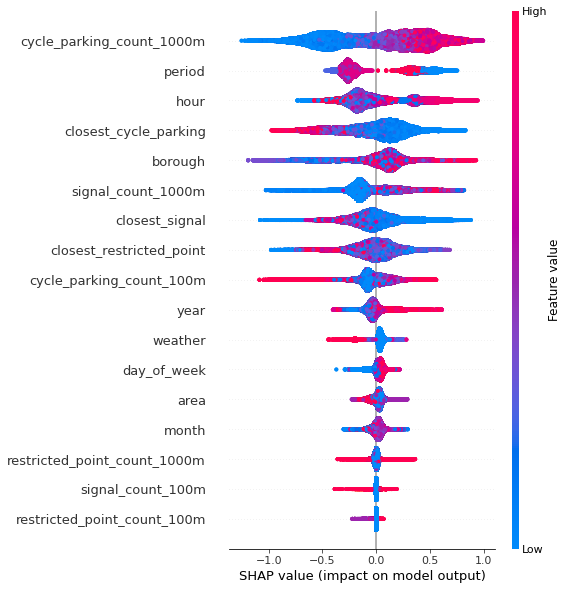

In [24]:
# Feature importance 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

We see from the Shapley plot above that cycle_parking_count_1000m is the most important feature, followed by period, hour, and closest_cycle_parking.
This indicates that the most important features when predicting the number of cyclists are the cycle parking and the time of day (period, hour).

### Investigating Female Cycling
Here we further investigate the sex differences in London cycling. 
We prepare some data for visualisation in Tableau, as Tableau has the capacity to create very visually appealing and interactive dashboards for stakeholders (__sex_differences_dashboard.twbx__).

In [25]:
# Prepare sex differences data for use in Tableau dashboard   

sex_differences = london[london['area']=='Outer'][['borough', 'date', 'year', 'male', 'female']]
sex_differences = sex_differences.groupby(['borough', 'date', 'year']).sum().reset_index()

sex_differences['sex_difference'] = sex_differences['male'] - sex_differences['female']
sex_differences['female_pct'] = sex_differences['female'] / (sex_differences['male'] + sex_differences['female'])

sex_differences = sex_differences.replace('&', 'and', regex=True)
sex_differences.to_csv('london_sex_differences/sex_differences_tab.csv', index=False)

In [26]:
# Prepare infrastructure data for use in Tableau dashboard  
borough_infrastructure = pd.read_csv('london_infrastructure/borough_infrastructure.csv')
borough_infrastructure = borough_infrastructure.replace('&', 'and', regex=True)
borough_infrastructure.to_csv('london_sex_differences/borough_infrastructure_tab.csv', index=False)

[Text(0.5, 1.0, 'Percentage of Total Cyclists that are Female'),
 Text(0.5, 0, 'Female Cyclists (%)'),
 Text(0, 0.5, 'Time of Day')]

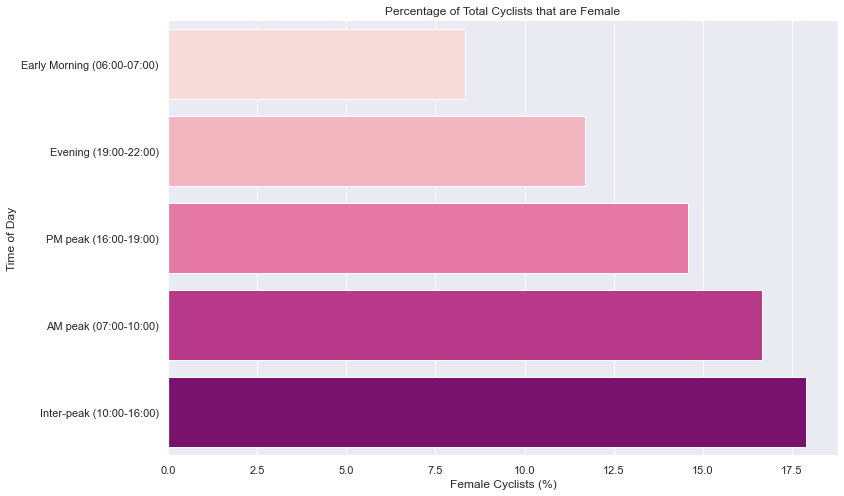

In [27]:
# What time of day (period) sees a higher % of female cyclists? 
cycle_periods = london[london['area']=='Outer'].groupby(['period']).sum().reset_index()
cycle_periods['female_pct'] = 100*cycle_periods['female'] / (cycle_periods['male']+cycle_periods['female'])
cycle_periods.sort_values(by='female_pct', inplace=True)
cycle_periods = cycle_periods[['period', 'female_pct']].reset_index(drop=True)

# Display on plot 
sns.set(rc = {'figure.figsize':(12, 8)})
sns.barplot(data=cycle_periods, x='female_pct', y='period', palette='RdPu').set(
    title='Percentage of Total Cyclists that are Female', xlabel='Female Cyclists (%)', ylabel='Time of Day')